In [64]:
import pandas as pd
import numpy as np
import random
import scipy.stats
import math
from matplotlib import pyplot as plt
from random import sample
from scipy.stats import chisquare
from scipy.stats import geom
from scipy import stats
z90 = 1.645
z95 = 1.96
z99 = 2.576

In [65]:
dokta = pd.read_csv("data/DOKTA.csv", na_values = "null")
dokta.dropna(inplace=True)
dokta.reset_index(inplace=True,drop=True)
dokta.info()
len(dokta)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 7 columns):
Date         5641 non-null object
Open         5641 non-null float64
High         5641 non-null float64
Low          5641 non-null float64
Close        5641 non-null float64
Adj Close    5641 non-null float64
Volume       5641 non-null float64
dtypes: float64(6), object(1)
memory usage: 308.6+ KB


5641

In [66]:
dokta["Change in Price"] = dokta["Close"] - dokta["Close"].shift()
dokta["Outcome"] = dokta["Change in Price"].apply(lambda x: "Up" if x>= 0 else ("Down" if pd.notnull(x)==True else ""))
#dokta["Days to Up"]
dokta.head(20)
len(dokta)

5641

In [67]:
# if previous day is up and actual day is up, it's 1
# if previous day is down and actual day is up, count how many days were down since the last up
# if actual day is down simply don't count.
# at last, you don't need the index num 0 row, drop it.

count = 1
days_to_up = list()
for a in dokta["Outcome"].index.tolist()[1:]:
    #print(a)
    oper = dokta["Outcome"][a]
    prev = dokta["Outcome"][a-1]
    #print("previous is: ", prev)
    #print("actual is: ", oper)

    if oper == "Down":
        count = count + 1
        days_to_up.append("-")
    elif oper == "Up" and prev == "Down":
        #print("Count is: ", count)
        days_to_up.append(count)
        count = 1
    else:
        count = 1
        days_to_up.append(count)
        
days_to_up = np.array(days_to_up)
len(days_to_up)

5640

In [68]:
dokta.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Change in Price,Outcome
0,2000-05-10,19.905212,19.905212,18.483412,19.194311,16.224569,89814.0,NaN,
1,2000-05-11,19.194311,19.194311,18.483412,18.957344,16.024269,22057.0,-0.236967,Down
2,2000-05-12,20.616114,20.616114,19.194311,20.616114,17.426392,84725.0,1.658770,Up
3,2000-05-15,21.800947,21.800947,20.616114,21.327015,18.027306,26617.0,0.710901,Up
4,2000-05-16,21.327015,21.327015,20.379147,20.616114,17.426392,33912.0,-0.710901,Down


In [69]:
dokta_d = dokta.copy()
dokta_d.drop([0],inplace=True)
dokta_d.reset_index(inplace=True,drop=True)
dokta_d["Days to Up"] = days_to_up
dokta_d.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Change in Price,Outcome,Days to Up
0,2000-05-11,19.194311,19.194311,18.483412,18.957344,16.024269,22057.0,-0.236967,Down,-
1,2000-05-12,20.616114,20.616114,19.194311,20.616114,17.426392,84725.0,1.658770,Up,2
2,2000-05-15,21.800947,21.800947,20.616114,21.327015,18.027306,26617.0,0.710901,Up,1
3,2000-05-16,21.327015,21.327015,20.379147,20.616114,17.426392,33912.0,-0.710901,Down,-
4,2000-05-17,20.379147,20.379147,19.431278,19.668245,16.625177,37921.0,-0.947869,Down,-
5,2000-05-18,18.957344,18.957344,18.483412,18.957344,16.024269,3714.0,-0.710901,Down,-
6,2000-05-22,19.194311,19.194311,18.246445,18.957344,16.024269,12685.0,0.000000,Up,4
7,2000-05-23,19.194311,19.194311,18.246445,18.957344,16.024269,12685.0,0.000000,Up,1
8,2000-05-26,19.668245,19.668245,19.194311,19.194311,16.224569,3277.0,0.236967,Up,1
9,2000-06-02,17.772511,17.772511,17.061611,17.535545,14.822450,31318.0,-1.658766,Down,-


In [70]:
dokta_t = dokta_d.set_index("Date")
dokta_t = dokta_t.T

In [71]:
# probably there are easier ways to accomplish what i've done here. just a palliative solution in this block.
# still it works as should be.

p = sum(dokta_d.Outcome == "Up") / len(dokta_d)
up_counts = dokta_d["Days to Up"].value_counts()
# has to be at least 5 for the chi2 distribution.
bins = list()
days = list()
last_bin = 0
last_geo = 0
for i in range(1,20):
    try:
        if up_counts[i] < 5:
                last_bin = last_bin + up_counts[i]
        else:
            days.append(i)
            bins.append(up_counts[i])
    except:
        pass

bins.append(last_bin)
days.append(max(days)+1)

geom_pd = geom.pmf(days, p)

contingency = pd.DataFrame(bins,index=days,columns=["Observed"])
contingency["Geometric Distribution"] = geom_pd * sum(contingency["Observed"])
contingency.index.name = "Days"
contingency

,Observed,Geometric Distribution
Days,,
1,1705,1709.401596
2,755,768.321462
3,345,345.335976
4,187,155.217500
5,64,69.765312
6,33,31.357281
7,9,14.094097
8,5,6.334847
9,2,2.847312


In [72]:
print('''H0: dokta stock being up or down on a given day is independent from all other days.
HA: dokta stock being up or down on a given day is not independent from all other days.''')
p

H0: dokta stock being up or down on a given day is independent from all other days.
HA: dokta stock being up or down on a given day is not independent from all other days.


0.55053191489361697

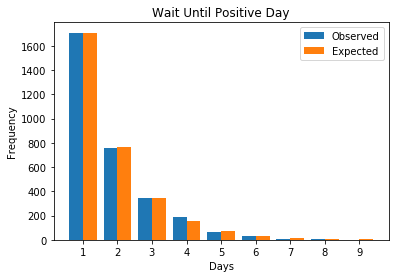

In [73]:
X = days
Y = contingency["Observed"]
Z = contingency["Geometric Distribution"]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Observed')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Expected')
  
plt.xticks(X_axis, X)
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.title("Wait Until Positive Day")
plt.legend()
plt.show()

In [74]:
chisquare(Y,Z)
# because pvalue is so big, we can't reject the notion BIST100 stock market being up or down on a given day is independent
# from all other days

Power_divergenceResult(statistic=9.687548706449947, pvalue=0.28764422922594512)